In [82]:
import ibm_boto3
from botocore.client import Config
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import pickle

In [83]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-77f70a3a-5e9a-46b4-a21d-3ad0d8fca175',
    'IBM_API_KEY_ID': '5MePM5YuklpJp-yySZg9yMGUMnIVTxeMsva00RgL7GOY',
    'ENDPOINT': 'https://s3.private.us.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'pca-donotdelete-pr-6hy02yj5ahnoyp',
    'FILE': 'household_power_consumption.txt'
}

cos = ibm_boto3.client('s3',
                    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
                    ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
                    ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
                    config=Config(signature_version='oauth'),
                    endpoint_url=credentials_1['ENDPOINT'])

def get_file(filename):
    fileobject = cos.get_object(Bucket=credentials_1['BUCKET'], Key=filename)['Body']
    return fileobject

In [84]:
data = pd.read_csv(get_file("household_power_consumption.txt"), sep=";", 
parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
low_memory=False, na_values=['nan','?'], index_col='dt')

print("Shape of data: " + str(data.shape))

Shape of data: (2075259, 7)


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [86]:
data = data.dropna(how="all")

In [87]:
data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

<AxesSubplot:>

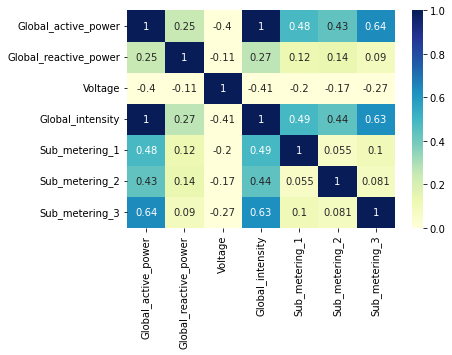

In [88]:
sns.heatmap(data.corr(), vmax=1, vmin=0, cmap="YlGnBu", annot=True)

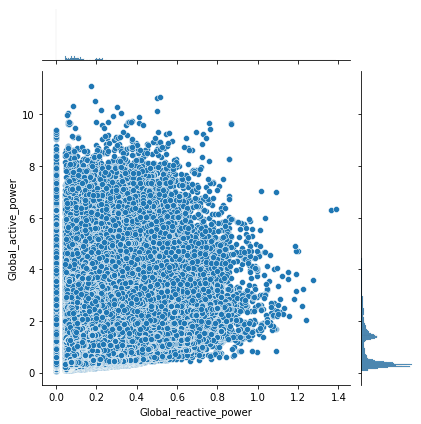

In [89]:
sns.jointplot(x=data["Global_reactive_power"], y=data["Global_active_power"], kind="scatter")

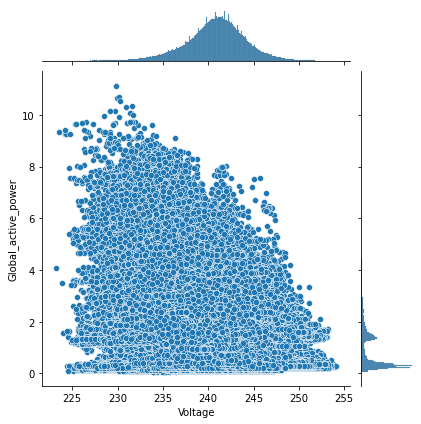

In [90]:
sns.jointplot(x=data["Voltage"], y=data["Global_active_power"], kind="scatter")

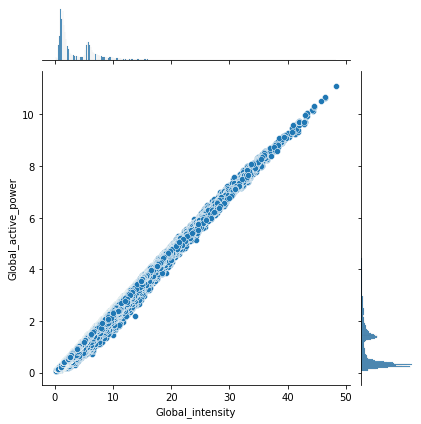

In [91]:
sns.jointplot(x=data["Global_intensity"], y=data["Global_active_power"], kind="scatter")

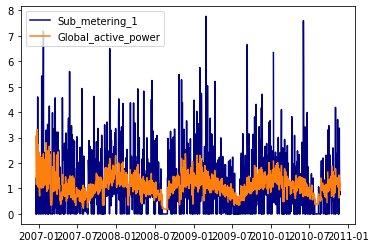

In [92]:
plt.plot(data.iloc[:,4:5].resample("D").mean(), color="navy", label="Sub_metering_1")
plt.plot(data.iloc[:,0:1].resample("D").mean(), "tab:orange", label="Global_active_power")
plt.legend()

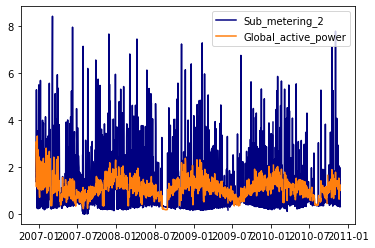

In [93]:
plt.plot(data.iloc[:,5:6].resample("D").mean(), color="navy", label="Sub_metering_2")
plt.plot(data.iloc[:,0:1].resample("D").mean(), "tab:orange", label="Global_active_power")
plt.legend()

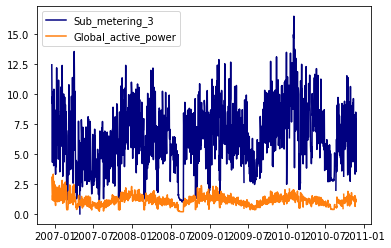

In [94]:
plt.plot(data.iloc[:,6:7].resample("D").mean(), color="navy", label="Sub_metering_3")
plt.plot(data.iloc[:,0:1].resample("D").mean(), "tab:orange", label="Global_active_power")
plt.legend()

In [95]:
x = data.iloc[:, 2:7]
y = data.iloc[:, 0:1]
print("x shape: " + str(x.shape))
print("y shape: " + str(y.shape))

x shape: (2049280, 5)
y shape: (2049280, 1)


In [96]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)
print("x_train :" + str(x_train.shape))
print("x_test :" + str(x_test.shape))
print("y_train :" + str(y_train.shape))
print("y_test :" + str(y_test.shape))

x_train :(1639424, 5)
x_test :(409856, 5)
y_train :(1639424, 1)
y_test :(409856, 1)


In [97]:
lr = LinearRegression()
lr.fit(x_train, y_train)
prediction = lr.predict(x_test)

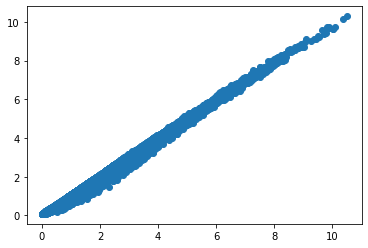

In [98]:
plt.scatter(y=y_test, x=prediction)

In [99]:
print("Mean absolute error: " + str(metrics.mean_absolute_error(y_test, prediction)))
print("Mean squared error: " + str(metrics.mean_squared_error(y_test, prediction)))
print("Root mean squared error: " + str(np.sqrt(metrics.mean_squared_error(y_test, prediction))))
print("R^2 :" + str(metrics.r2_score(y_test, prediction)))

Mean absolute error: 0.029694263050756724
Mean squared error: 0.0020104299177694618
Root mean squared error: 0.04483781794166016
R^2 :0.9981993845867724


In [100]:
!pip install ibm_watson_machine_learning

In [101]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "0iiOUE_frC77F7i8dmSNkR8W0XE86s85eIsThHAdETCS"
}

client = APIClient(wml_credentials)

In [102]:
def guid_form_space_name(client, space_name):
    space = client.spaces.get_details()
    return (next(item for item in space["resources"] if item["entity"]["name"] == space_name)["metadata"]["id"])

In [103]:
space_uid = guid_form_space_name(client, "models")
print("Space UID: " + space_uid)

Space UID: d1a8da11-3a8a-4431-944c-3548b1c6d5e1


In [104]:
client.set.default_space(space_uid)

'SUCCESS'

In [105]:
client.software_specifications.list(limit=200)

-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
runtime-22.1

In [106]:
software_spec_uid = client.software_specifications.get_uid_by_name("runtime-22.1-py3.9")
software_spec_uid

'12b83a17-24d8-5082-900f-0ab31fbfd3cb'

In [107]:
model_details = client.repository.store_model(model=lr,meta_props={
    client.repository.ModelMetaNames.NAME: "Linear_regression",
    client.repository.ModelMetaNames.TYPE: "scikit-learn_1.0",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid })

model_id = client.repository.get_model_uid(model_details)
model_id

This method is deprecated, please use get_model_id()


'8caad72a-a2f7-44ff-93b9-5cbcef23d8a9'

In [108]:
lr.predict([x_test.iloc[0,:].values])

array([[3.89455892]])